In [1]:
# !pip install -U transformers
# !pip install -U accelerate 
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install seaborn --upgrade

# !pip install -U openpyxl

# Don't do in production. Doing now to keep output clean for understanding
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")

In [4]:
df.isnull().sum()
df = df.dropna()

df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [18]:
df.shape

(18281, 7)

In [5]:
df['label'].value_counts()

label
0    10361
1     7920
Name: count, dtype: int64

## Dataset Analysis

In [6]:
import matplotlib.pyplot as plt

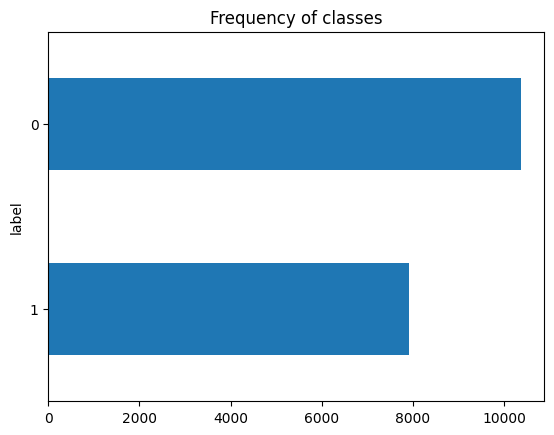

In [7]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of classes")
plt.show()

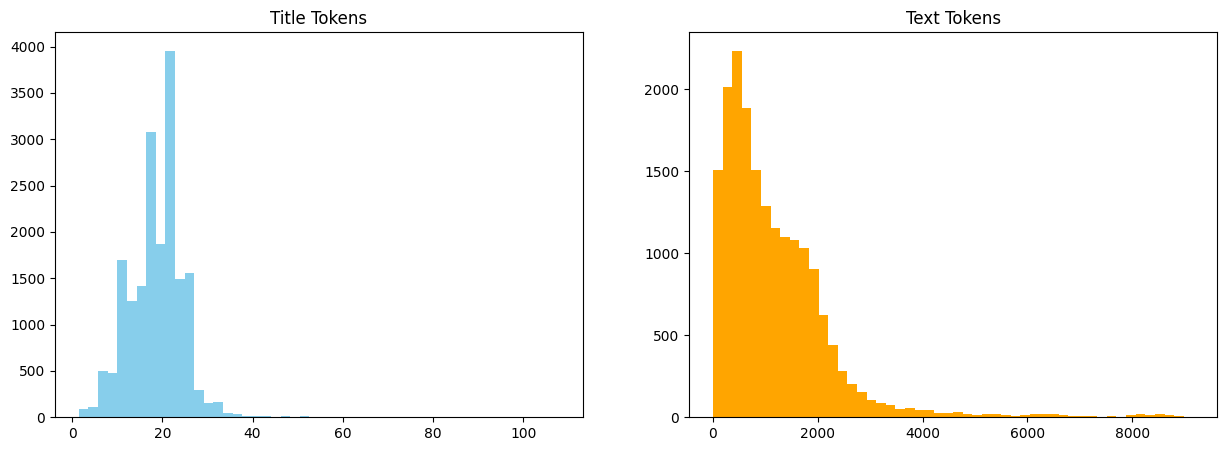

In [8]:
# 1.5 tokens per word on average
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'] = df['text'].apply(lambda x:len(x.split())*1.5)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color='skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50,color ='orange')
ax[1].set_title("Text Tokens")

plt.show()

## Data Loader and Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

#70% for training, 20% test, 10% validation
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size =1/3, stratify=test['label'])
train.shape, test.shape, validation.shape

((12796, 7), (3656, 7), (1829, 7))

In [10]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train":Dataset.from_pandas(train, preserve_index=False),
    "test":Dataset.from_pandas(test, preserve_index=False),
    "validation":Dataset.from_pandas(validation, preserve_index=False)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

## Data Tokenization

In [11]:
from transformers import AutoTokenizer

text = "Machine learning is awesome!! Thanks KGP Talkie."

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

# model_ckpt = "huawei-noah/TinyBERT_General_4L_321D"
# tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# tinybert_tokens = tinybert_tokenizer.tokenize(text)

In [12]:
distilbert_tokenizer, mobilebert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=10000

In [13]:
def tokenize(batch):
    temp = distilbert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 7207, 1521, 1055, 1523, 2053, 1011, 4875, 4224, 1524, 2058, 7795, 2097, 2599, 2000, 2162, 2007, 3607, 1012, 5432, 1997, 29175, 2015, 3472, 2236, 24654, 3877, 102], [101, 2762, 1024, 20731, 19239, 2046, 5030, 7491, 16455, 20730, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [14]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

## Model Building

In [15]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real":0, "Fake":1}
id2label ={0:"Real", 1:"Fake"}

model_ckpt = "distilbert-base-uncased"

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model.config.id2label

{0: 'Real', 1: 'Fake'}

In [17]:
# Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions,labels = eval_pred
    predictions=np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, reference=labels)


KeyboardInterrupt



In [ ]:
from transformers import TrainingArguments

batch_size = 32
training_dir ="train_dir"

training_args = TrainingArguments(output_dir=training_dir,
                                  overwrite_output_dir=True,
                                  num_train_epochs=2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy ='epoch')

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, compute_metrics=compute_metrics_evaluate,
                  train_dataset=encoded_dataset['train'],
                  eval_dataset=encoded_dataset['validation'],
                  tokenizer=distilbert_tokenizer)

In [ ]:
trainer.train()

In [ ]:
preds_output = trainer.predict(encoded_dataset['test'])

In [ ]:
preds_output.metrics

In [ ]:
y_pred =np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id)))

## Benchmarking

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels,preds)

    return {"accuracy":acc, "f1":f1}

In [ ]:
model_dict={
    "bert-base":'bert-base-uncased',
    'distilbert':'distilbert-base-uncased'}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id,id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

    def local_tokenizer(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True)
        return temp

    encoded_dataset = dataset.map(local_tokenizer, batched=true, batch_size=None)
    trainer = Trainer(model=model, compute_metrics=compute_metrics,
                        train_dataset=encoded_dataset['train'],
                        eval_dataset=encoded_dataset['validation'],
                        tokenizer=distilbert_tokenizer)

    trainer.train()
    preds = trainer.predict(encoded_dataset['test'])
    return preds.metrics

import time
model_performance ={}
for model_name in model_dict:
    print("\n\n")
    print("Training Model:", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()

    model_performance[model_name] = {model_name:result, "time taken":end-start}

## Model Load and Save

In [ ]:
trainer.save_model("fake_news")

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification", model='fake_news')

In [ ]:
classifier("some text data")